In [322]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import wfdb
import seaborn as sns
import os
import requests

from sklearn.svm import SVC,SVR

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

from emg_processor import EMGProcessor
from emg_feature_extractor import EMGFeatureExtractor
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
# Constants:
sampling_rate = 250  # Sampling frequency in Hz
low_cutoff = 1 # Low cutoff for bandpass filter (in Hz) #1,10,20,30
high_cutoff = 3 # High cutoff for bandpass filter (in Hz)#40,55
notch_freq = 50.0  # Frequency to remove using notch filter (in Hz)
window_size = 147# Size of the window for feature extraction (in samples)# 147,23,12,8,6,5
k = 51 #number of cycles # 51,321,621,921,1221,1521
sec = 580 # sec for each frequency: 580, 94,48,32,25,20 sec for each frequency

# Read Data and Label

In [680]:
import wfdb

# Path to the recording (without file extension)
file_path = "eeg_recording"
# Read the record and metadata
record = wfdb.rdrecord(file_path)

# Access the signals and metadata
signals = record.p_signal  # Processed (physical) signals
sampling_rate = record.fs  # Sampling frequency
signal_names = record.sig_name  # Channel names
units = record.units  # Units for each signal

# Print details
print("Sampling Rate:", sampling_rate)
print("Signal Names:", signal_names)
print("Units:", units)
print("Signals Shape:", signals.shape)

# Example: Access first 10 samples of each signal
print("First 10 Samples of Signals:")
print(signals[:10, :])  # Rows are samples, columns are channels


Sampling Rate: 250
Signal Names: ['O1', 'O2', 'T3', 'T4']
Units: ['mV', 'mV', 'mV', 'mV']
Signals Shape: (49856, 4)
First 10 Samples of Signals:
[[146.6749089  166.57469787 109.91007233 111.33184138]
 [148.17202587 171.85555131 109.88563288 114.30926449]
 [153.32644097 189.59286228 110.66503897 129.31302293]
 [154.16126743 194.28473164 110.54443557 134.97323227]
 [148.67106486 178.39549712 109.06212951 122.82267985]
 [143.77274573 165.89569925 107.69723909 110.32295621]
 [145.4106768  169.08621487 107.74930576 112.90727767]
 [150.43201484 181.58601274 108.53774382 125.40700131]
 [151.23434574 190.51301098 108.45114314 132.53888023]
 [145.90662097 178.01321312 107.03152959 120.83672121]]


In [681]:
labels_path = "eeg_recording_label"
labels_record = wfdb.rdrecord(labels_path)
# Access the signals and metadata
labels = labels_record.p_signal  # Processed (physical) signals
labels_sampling_rate = labels_record.fs  # Sampling frequency
labels_signal_names = labels_record.sig_name  # Channel names
labels_units = labels_record.units  # Units for each signal

# Print details
print("Sampling Rate:", labels_sampling_rate)
print("Signal Names:", labels_signal_names)
print("Units:", labels_units)
print("Signals Shape:", labels.shape)

# Example: Access first 10 samples of each signal
print("First 10 Samples of Signals:")
print(labels[:10, :])  # Rows are samples, columns are channels

Sampling Rate: 250
Signal Names: ['Frequency']
Units: ['Hz']
Signals Shape: (49856, 1)
First 10 Samples of Signals:
[[1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]
 [1.70000005]]


In [682]:
# Ensure labels is a valid iterable (e.g., a list or numpy array)
if labels is None or len(labels) == 0:
    print("The labels array is empty or not defined.")
else:
    # Create a dictionary to group elements in labels
    labels_dict = {}

    # Iterate over the labels array and group by unique label values
    for i, label in enumerate(labels):
        # Convert the label to a tuple to ensure it's hashable
        hashable_label = tuple(label) if isinstance(label, np.ndarray) else label
        # Check if the label is already a key in the dictionary
        if hashable_label not in labels_dict:
            labels_dict[hashable_label] = []
        # Append the current index to the label's list
        labels_dict[hashable_label].append(i)

    # Print the dictionary in a readable format
    print("Labels Dictionary:")
    for key, value in labels_dict.items():
        print(f"Label {key}: Indices {len(value)}")


Labels Dictionary:
Label (1.700000047683716,): Indices 37370
Label (0.0,): Indices 12486


In [683]:
# Extract O1 and O2 channels (first and second columns)
o1_o2_channels = signals[:, 0:2]  # Select all rows and the first two columns (O1 and O2)

# Print the first 10 samples of O1 and O2 channels
print("First 10 Samples of O1 and O2 Channels:")
print(o1_o2_channels[:10, :])


First 10 Samples of O1 and O2 Channels:
[[146.6749089  166.57469787]
 [148.17202587 171.85555131]
 [153.32644097 189.59286228]
 [154.16126743 194.28473164]
 [148.67106486 178.39549712]
 [143.77274573 165.89569925]
 [145.4106768  169.08621487]
 [150.43201484 181.58601274]
 [151.23434574 190.51301098]
 [145.90662097 178.01321312]]


# 1.7 Hz data windowing and getting avg of windows

## Basic operations

In [684]:
# Ensure signals and labels are valid and have compatible lengths
if signals is None or len(signals) == 0:
    print("The signals array is empty or not defined.")
elif labels is None or len(labels) == 0:
    print("The labels array is empty or not defined.")
elif len(signals) != len(labels):
    print("The lengths of signals and labels do not match.")
else:
    # Define the label you are interested in (e.g., 1.7 Hz)
    target_label = (labels[0][0],)  # Ensure it's a tuple if labels are stored as tuples  1.7000335080035638

    # Check if the target label exists in the dictionary
    if target_label not in labels_dict:
        print(f"Label {target_label} not found in the labels dictionary.")
    else:
        # Get the indices corresponding to the target label
        target_indices = labels_dict[target_label]

        # Extract the signals corresponding to these indices
        target_signals = signals[target_indices, :]  # Assuming signals is a 2D numpy array

        # Print the extracted signals
        print(f"Signals for label {target_label}:")
        print(target_signals)

        # Optionally, save the signals for further processing
        # Example: Save as a numpy file
        np.save("signals_1.7Hz.npy", target_signals)
        print(f"Signals saved to 'signals_1.7Hz.npy'")


Signals for label (1.700000047683716,):
[[146.6749089  166.57469787 109.91007233 111.33184138]
 [148.17202587 171.85555131 109.88563288 114.30926449]
 [153.32644097 189.59286228 110.66503897 129.31302293]
 ...
 [108.99475731 140.40380174  83.41132785 104.17118045]
 [105.43726697 128.08514425  82.64095373  93.70134588]
 [103.87051666 121.86302759  82.25948572  87.10344898]]
Signals saved to 'signals_1.7Hz.npy'


In [685]:
# Extract O1 and O2 channels (first and second columns)
o1_o2_channels = target_signals[:, 0:2]  # Select all rows and the first two columns (O1 and O2)
t1_t2_channels = target_signals[:, 2:4]  # Select all rows and the next two columns (T1 and T2)

# Print the first 10 samples of O1 and O2 channels
print("First 10 Samples of O1 and O2 Channels:")
print(o1_o2_channels.shape)

First 10 Samples of O1 and O2 Channels:
(37370, 2)


In [686]:
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

# Define the filter function
def apply_filter(data, sampling_rate, cutoff, filter_type, order=4):
    """
    Apply a Butterworth filter (lowpass, highpass, bandpass) to the data.

    :param data: Input signal data (2D array).
    :param sampling_rate: Sampling frequency of the data.
    :param cutoff: Cutoff frequency (or frequencies for bandpass) for the filter.
    :param filter_type: 'low', 'high', or 'band'.
    :param order: Order of the Butterworth filter.
    :return: Filtered data (same shape as input).
    """
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    normalized_cutoff = np.array(cutoff) / nyquist  # Normalize cutoff frequency
    b, a = butter(order, normalized_cutoff, btype=filter_type, analog=False)
    filtered_data = filtfilt(b, a, data, axis=0)  # Apply filter along the columns
    return filtered_data

# Define the notch filter function
def apply_notch_filter(data, sampling_rate, notch_freq, quality_factor=30.0):
    """
    Apply a Notch filter to remove a specific frequency.

    :param data: Input signal data (2D array).
    :param sampling_rate: Sampling frequency of the data.
    :param notch_freq: Frequency to remove (e.g., 50 Hz for power line noise).
    :param quality_factor: Quality factor for the Notch filter (higher = narrower band).
    :return: Filtered data (same shape as input).
    """
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    normalized_notch = notch_freq / nyquist
    b, a = iirnotch(normalized_notch, quality_factor)
    filtered_data = filtfilt(b, a, data, axis=0)  # Apply filter along the columns
    return filtered_data

# # Filter parameters
# sampling_rate = 250  # Sampling frequency in Hz
# low_cutoff = 10.0  # Low cutoff for bandpass filter (in Hz)
# high_cutoff = 40.0  # High cutoff for bandpass filter (in Hz)
# notch_freq = 50.0  # Frequency to remove using notch filter (in Hz)

# Apply bandpass filter
bandpass_filtered_data = apply_filter(o1_o2_channels, sampling_rate, [low_cutoff, high_cutoff], 'band')

# Apply notch filter
notch_filtered_data = apply_notch_filter(bandpass_filtered_data, sampling_rate, notch_freq)

# Print the first 10 samples of the bandpass and notch filtered data
print("First 10 Samples of Bandpass + Notch Filtered O1 and O2 Channels:")
print(notch_filtered_data[:10])


First 10 Samples of Bandpass + Notch Filtered O1 and O2 Channels:
[[2.82642907 3.91984971]
 [2.74980992 4.14038504]
 [2.6706297  4.35121945]
 [2.58764889 4.55304018]
 [2.49889052 4.74744716]
 [2.40455647 4.93382467]
 [2.30688818 5.10937664]
 [2.20728502 5.27215221]
 [2.10469315 5.42284709]
 [1.99739278 5.56299648]]


In [687]:

# window_size = 147
# Calculate the total number of full windows
num_windows = notch_filtered_data.shape[0] // window_size

# Reshape the data into windows of shape (250, 2), excluding leftovers
windowed_data = notch_filtered_data[:num_windows * window_size].reshape(num_windows, window_size, 2)

# Print the resulting shape of the windowed data
print(f"Shape of Windowed Data: {windowed_data.shape}")


# Calculate the average across all windows
average_window = np.mean(windowed_data, axis=0)

# Print the shape of the resulting average
print(f"Shape of the Average Window: {average_window.shape}")

# Print the average of the 19 windows
print("Average Window Data:")
#print(average_window)

Shape of Windowed Data: (254, 147, 2)
Shape of the Average Window: (147, 2)
Average Window Data:


## Plot

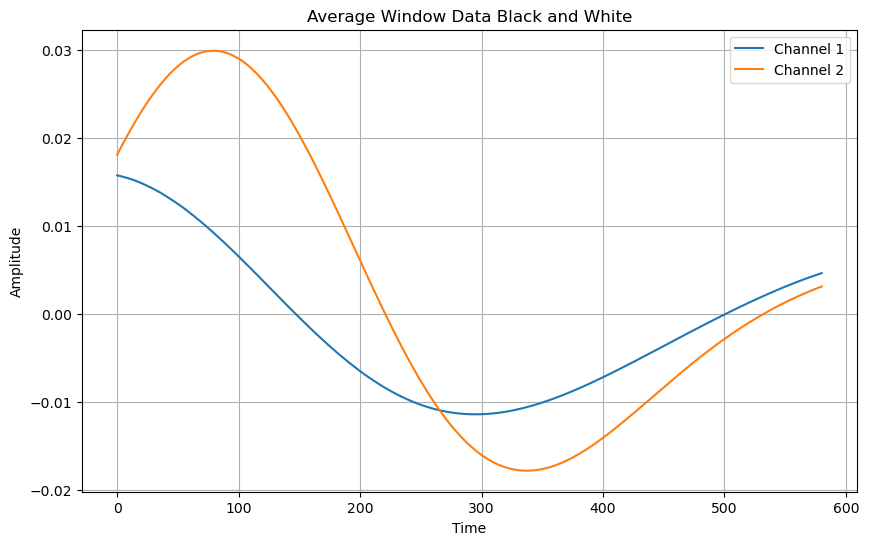

In [688]:
# Plot the average window data
time_in_ms = np.linspace(0, sec, len(average_window))  # 580 ms corresponds to 0.58 sec

plt.figure(figsize=(10, 6))
plt.plot(time_in_ms,average_window[:, 0], label='Channel 1')
plt.plot(time_in_ms,average_window[:, 1], label='Channel 2')
plt.title('Average Window Data Black and White')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [689]:
# Normalize function: min-max normalization to scale between 0 and 1
def normalize_channel(channel):
    return (channel - np.min(channel)) / (np.max(channel) - np.min(channel))

# Normalize the O1 and O2 channels
normalized_o1 = normalize_channel(average_window[:, 0])
normalized_o2 = normalize_channel(average_window[:, 1])

# Combine the normalized channels back into a single array
normalized_average_window = np.stack([normalized_o1, normalized_o2], axis=1)

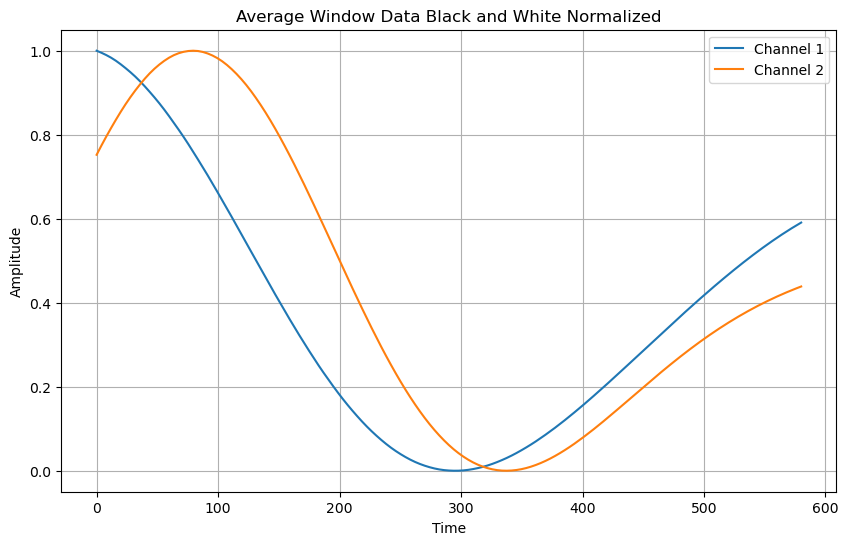

In [690]:
# Plot the average window data
plt.figure(figsize=(10, 6))
plt.plot(time_in_ms,normalized_average_window[:, 0], label='Channel 1')
plt.plot(time_in_ms,normalized_average_window[:, 1], label='Channel 2')
plt.title('Average Window Data Black and White Normalized')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

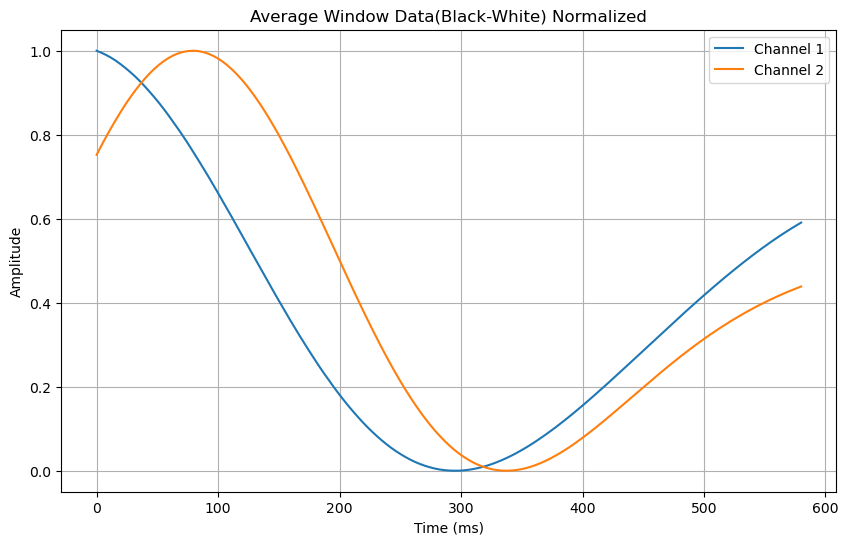

In [691]:

plt.figure(figsize=(10, 6))
plt.plot(time_in_ms, normalized_average_window[:, 0], label='Channel 1')
plt.plot(time_in_ms, normalized_average_window[:, 1], label='Channel 2')
plt.title('Average Window Data(Black-White) Normalized')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

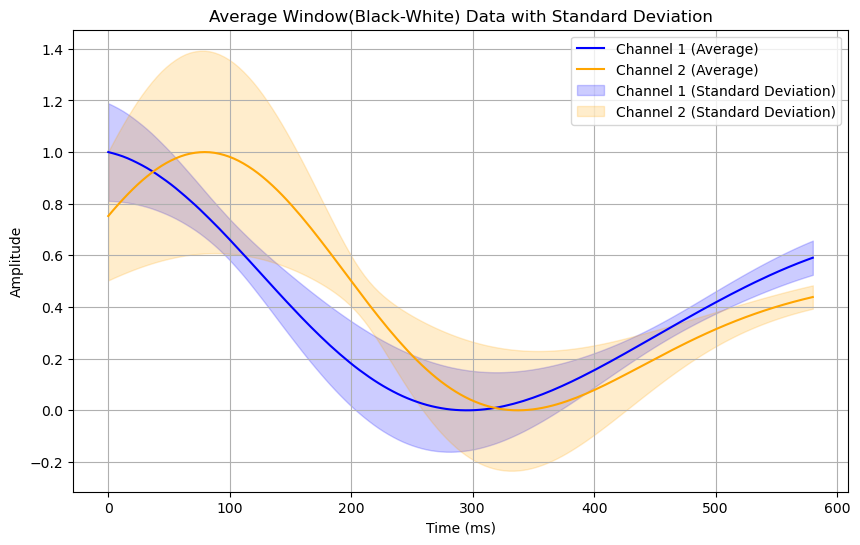

In [692]:

# Assuming 'normalized_average_window' is already defined and contains the average window data

# Calculate the standard deviation across all windows (axis=0)
standard_deviation_window = np.std(windowed_data, axis=0)

# Generate time in milliseconds (from 0 to 580 ms)
time_in_ms = np.linspace(0, 580, len(normalized_average_window))  # 580 ms corresponds to 0.58 sec

plt.figure(figsize=(10, 6))

# Plot average window data
plt.plot(time_in_ms, normalized_average_window[:, 0], label='Channel 1 (Average)', color='blue')
plt.plot(time_in_ms, normalized_average_window[:, 1], label='Channel 2 (Average)', color='orange')

# Plot standard deviation data (plus and minus the standard deviation around the average)
plt.fill_between(time_in_ms, 
                 normalized_average_window[:, 0] - standard_deviation_window[:, 0], 
                 normalized_average_window[:, 0] + standard_deviation_window[:, 0], 
                 color='blue', alpha=0.2, label='Channel 1 (Standard Deviation)')
                 
plt.fill_between(time_in_ms, 
                 normalized_average_window[:, 1] - standard_deviation_window[:, 1], 
                 normalized_average_window[:, 1] + standard_deviation_window[:, 1], 
                 color='orange', alpha=0.2, label='Channel 2 (Standard Deviation)')

plt.title('Average Window(Black-White) Data with Standard Deviation')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


## No matter

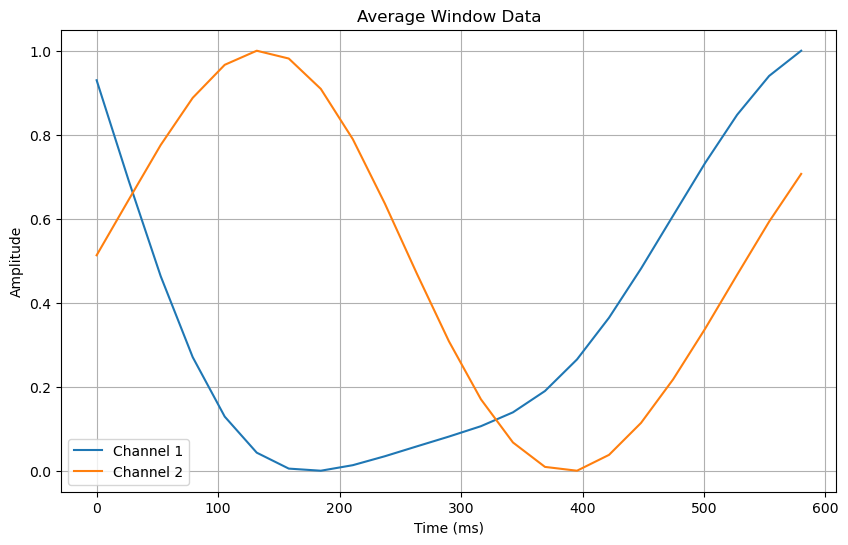

In [195]:
# Assuming the last sample corresponds to 0.58 seconds, which is the length of your window
# So, the number of samples (time steps) is equal to len(normalized_average_window)

time_in_ms = np.linspace(0, 580, len(normalized_average_window))  # 580 ms corresponds to 0.58 sec

plt.figure(figsize=(10, 6))
plt.plot(time_in_ms, normalized_average_window[:, 0], label='Channel 1')
plt.plot(time_in_ms, normalized_average_window[:, 1], label='Channel 2')
plt.title('Average Window Data')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [125]:
import matplotlib.pyplot as plt

# Plot the two channels
plt.figure(figsize=(10, 6))

# Plot the first channel (O1)
plt.plot(normalized_average_window[:, 0], label="O1 Channel")

# Plot the second channel (O2)
plt.plot(normalized_average_window[:, 1], label="O2 Channel")

# Add titles and labels
plt.title("Average of O1 and O2 Channels (250 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Signal Amplitude")
plt.legend()
plt.grid()

# Display the plot
plt.show()

1.7 hertz
0.597 0.58 sec-< 147 sample
250 sampling rate
147/250 = 0.588 sec
segmenting signal -Zget avg of each signal->
define that wave as 1.7 hertz 


SyntaxError: invalid syntax (2450170501.py, line 22)

(51, 2)
(51, 2)
(51, 2)
(51, 2)


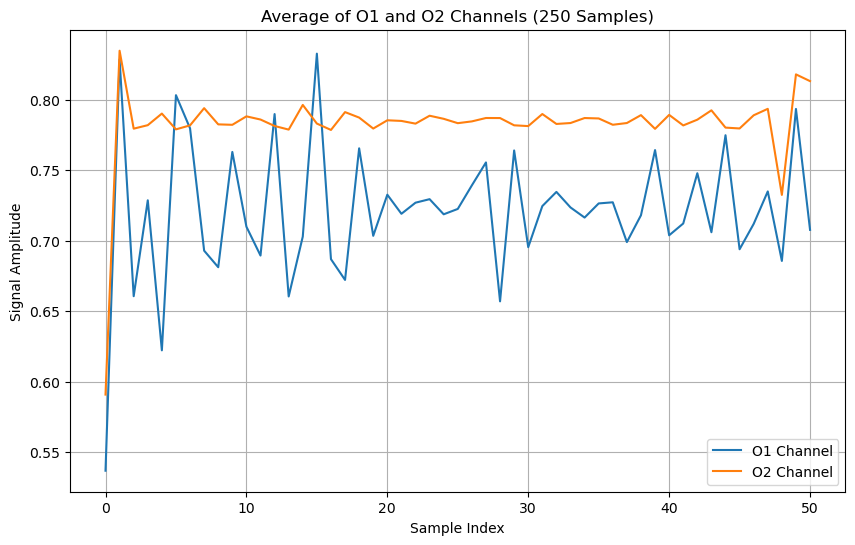

In [ ]:
# k =51
first = normalized_average_window[:k*1,]
second = normalized_average_window[k*1:k*2,]
third = normalized_average_window[k*2:k*3,]
fourth = normalized_average_window[k*3:k*4,]
print(first.shape), print(second.shape), print(third.shape), print(fourth.shape)

#get the first 4 seconds of the recording average:
average_window = np.average((first, second, third,fourth), axis=0)

# Plot the two channels
plt.figure(figsize=(10, 6))

# Plot the first channel (O1)
plt.plot(average_window[:, 0], label="O1 Channel")

# Plot the second channel (O2)
plt.plot(average_window[:, 1], label="O2 Channel")

# Add titles and labels
plt.title("Average of O1 and O2 Channels (250 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Signal Amplitude")
plt.legend()
plt.grid()

# Display the plot
plt.show()

(51, 2)
(51, 2)
(51, 2)
(51, 2)

Average of the First 25 Samples (O1, O2): [0.71759548 0.77912244]
Average of the Last 25 Samples (O1, O2): [0.72473105 0.78565512]


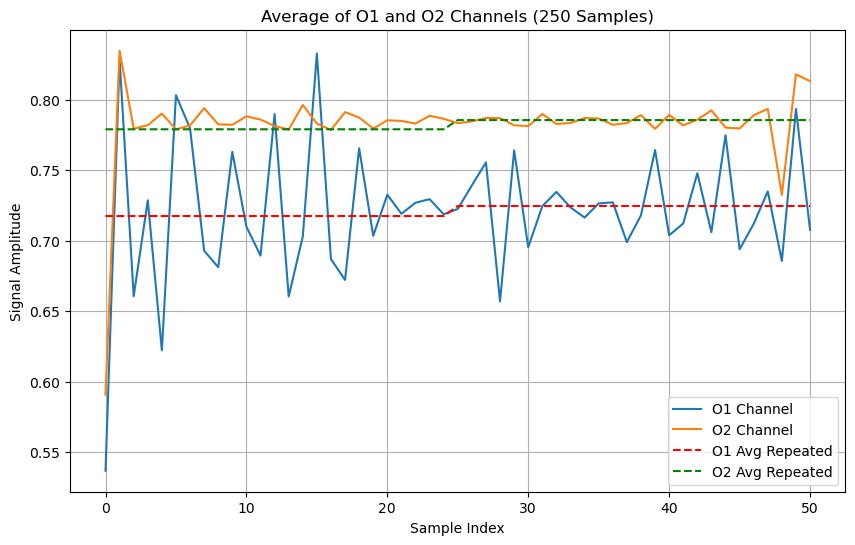

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming normalized_average_window is already defined with your data
k = 51
first = normalized_average_window[:k*1, :]
second = normalized_average_window[k*1:k*2, :]
third = normalized_average_window[k*2:k*3, :]
fourth = normalized_average_window[k*3:k*4, :]

# Check the shape of each segment
print(first.shape), print(second.shape), print(third.shape), print(fourth.shape)

# Get the average of the first 4 windows
average_window = np.average((first, second, third, fourth), axis=0)

# Calculate the average of the first 25 samples and last 25 samples
avg_first_25 = np.mean(average_window[:25, :], axis=0)
avg_last_25 = np.mean(average_window[25:, :], axis=0)

avg_of_avg_array = np.concatenate((np.tile(avg_first_25, (25, 1)), np.tile(avg_last_25, (26, 1))))


# Display the calculated averages
print("\nAverage of the First 25 Samples (O1, O2):", avg_first_25)
print("Average of the Last 25 Samples (O1, O2):", avg_last_25)

# Plot the two channels
plt.figure(figsize=(10, 6))

# Plot the first channel (O1)
plt.plot(average_window[:, 0], label="O1 Channel")

# Plot the second channel (O2)
plt.plot(average_window[:, 1], label="O2 Channel")

# Add average lines for the first and last 25 samples
# Plot the repeated averages
plt.plot(avg_of_avg_array[:, 0], label="O1 Avg Repeated", linestyle='--', color='r')
plt.plot(avg_of_avg_array[:, 1], label="O2 Avg Repeated", linestyle='--', color='g')


# Add titles and labels
plt.title("Average of O1 and O2 Channels (250 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Signal Amplitude")
plt.legend()
plt.grid()

# Display the plot
plt.show()


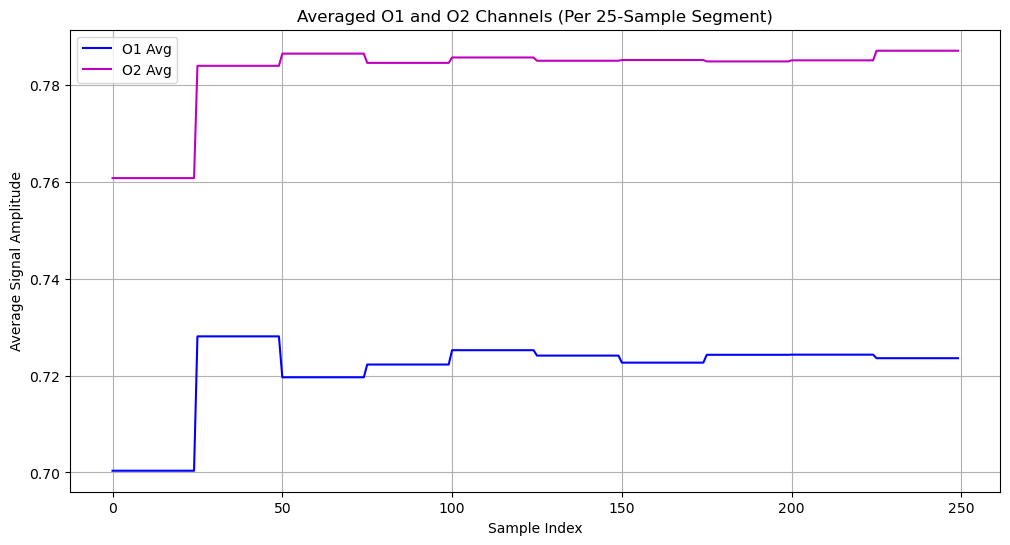

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (replace this with your actual normalized_average_window data)
# normalized_average_window = np.random.rand(250, 2)  # Uncomment this if you're testing with dummy data

# Step 1: Divide the data into 50-sample windows
window_size = 50
num_windows = normalized_average_window.shape[0] // window_size

# Store averages and sample indices for plotting
avg_values = []
sample_indices = []

for i in range(num_windows):
    # Extract the 50-sample window
    window_data = normalized_average_window[i * window_size:(i + 1) * window_size, :]
    
    # Step 2: Split into first 25 and second 25 samples
    first_25 = window_data[:25, :]
    second_25 = window_data[25:, :]
    
    # Step 3: Calculate the averages for both segments
    avg_first_25 = np.mean(first_25, axis=0)
    avg_second_25 = np.mean(second_25, axis=0)
    
    # Step 4: Repeat averages for plotting over respective sample ranges
    avg_values.extend([avg_first_25] * 25)
    avg_values.extend([avg_second_25] * 25)
    
    # Sample indices
    sample_indices.extend(range(i * window_size, i * window_size + 50))

# Convert to numpy arrays for easier handling
avg_values = np.array(avg_values)

# Step 5: Plotting the averages
plt.figure(figsize=(12, 6))

# Plotting O1 and O2 channel averages
plt.plot(sample_indices, avg_values[:, 0], label='O1 Avg', color='b')
plt.plot(sample_indices, avg_values[:, 1], label='O2 Avg', color='m')

# Titles and labels
plt.title('Averaged O1 and O2 Channels (Per 25-Sample Segment)')
plt.xlabel('Sample Index')
plt.ylabel('Average Signal Amplitude')
plt.legend()
plt.grid()

# Display the plot
plt.show()


# Articat removal


Signals shape: (49770, 4)
Labels shape: (49770,)
Sampling Rate: 250
Signal Names: ['O1', 'O2', 'T3', 'T4']
Labels Dictionary:
Label 1.700000047683716: 37290 indices
Label 0.0: 12480 indices
O1 and O2 Channels shape: (49770, 2)
First 10 samples of filtered data:
 [[ 1.27320887  1.68977354]
 [-0.99647254 -0.52784367]
 [-1.9077244  -1.42023027]
 [-1.24926298 -0.78893705]
 [ 0.05234169  0.45081244]
 [ 0.9048433   1.22811693]
 [ 0.87594852  1.1245368 ]
 [ 0.25515104  0.43217809]
 [-0.40956176 -0.29949248]
 [-0.77436024 -0.71859881]]
ICA components shape: (49770, 2)


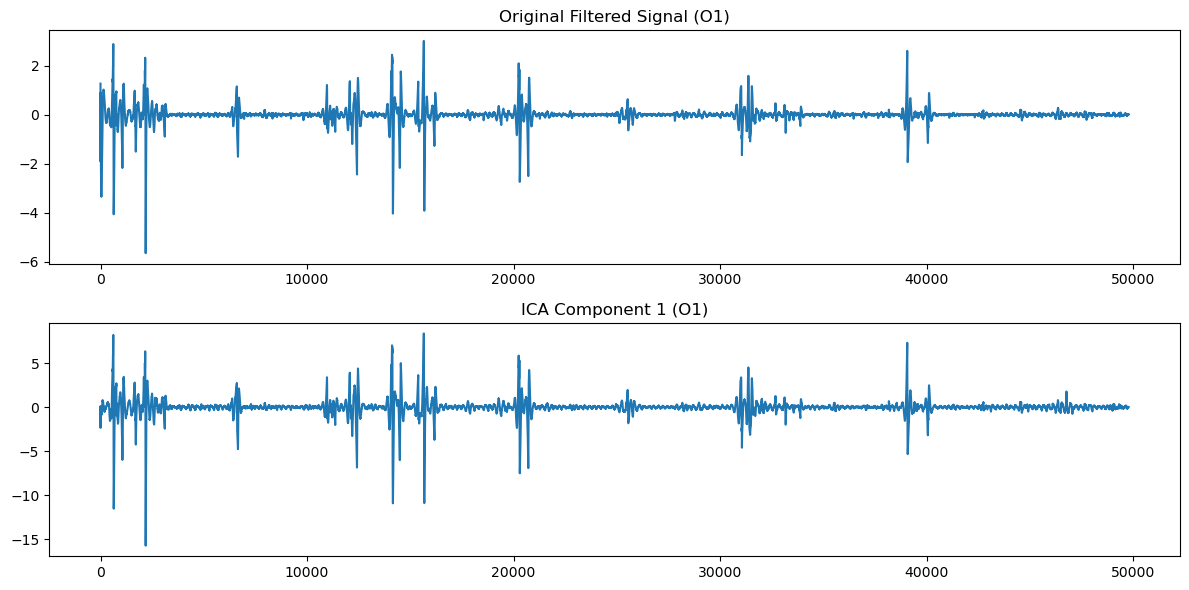

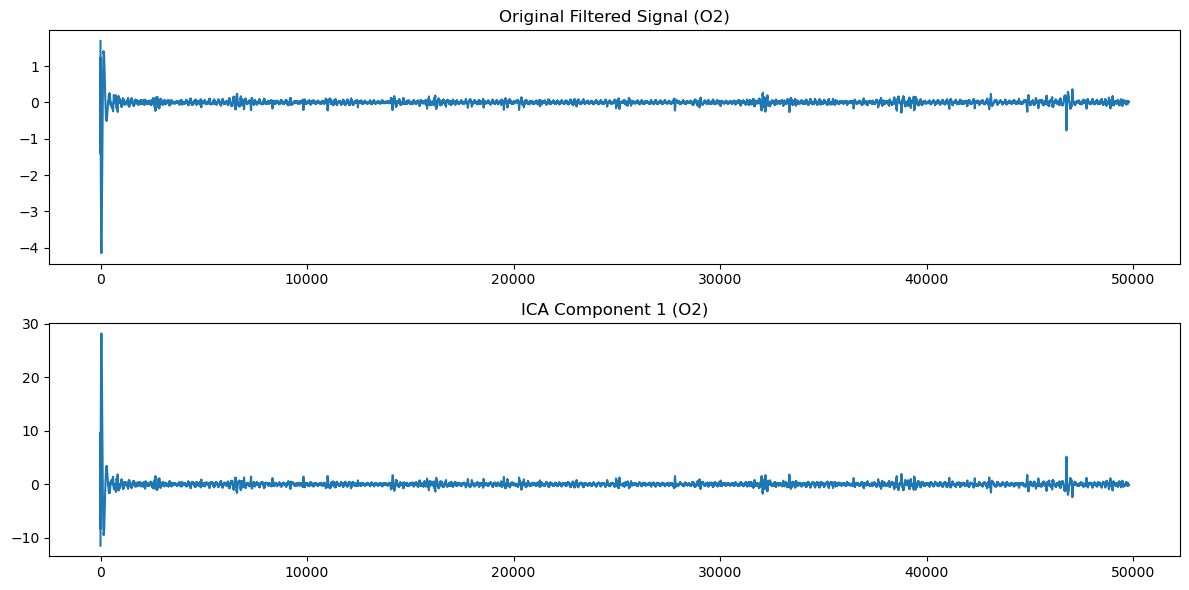

Windowed data shape: (338, 147, 2)
Epoch binary labels (1: flicker, 0: rest): (array([0, 1]), array([ 89, 249]))
Extracted features shape: (338, 2)


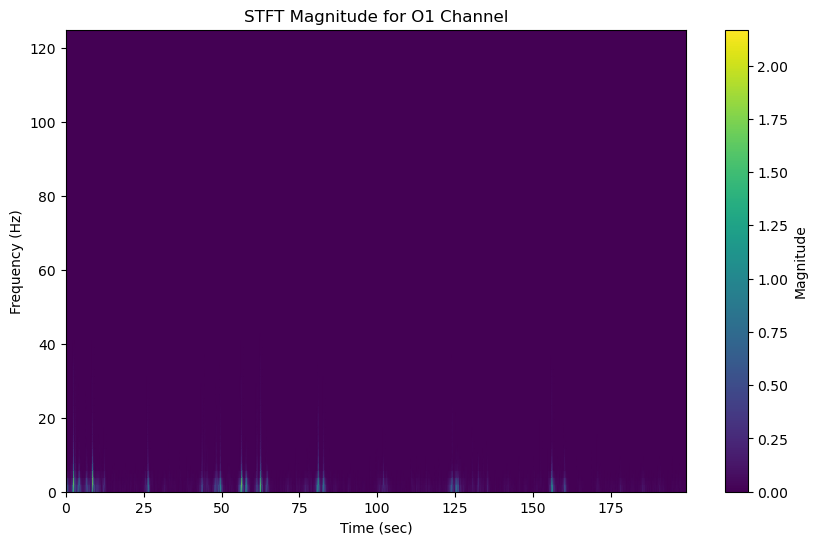

LDA Classification Accuracy: 0.7745098039215687
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.77      1.00      0.87        79

    accuracy                           0.77       102
   macro avg       0.39      0.50      0.44       102
weighted avg       0.60      0.77      0.68       102



/Users/hafizenursahbudak/opt/anaconda3/envs/nal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hafizenursahbudak/opt/anaconda3/envs/nal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hafizenursahbudak/opt/anaconda3/envs/nal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

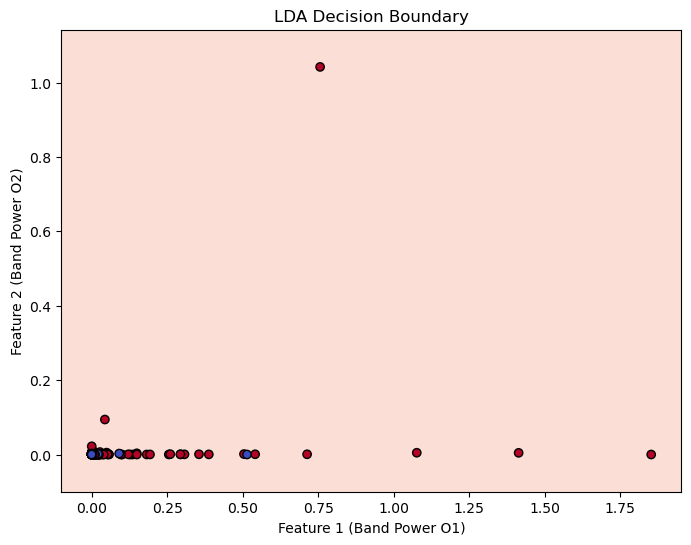

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from scipy.signal import butter, filtfilt, iirnotch, welch, stft
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, classification_report

###############################
# 1. DATA LOADING AND PREPROCESSING
###############################

# Read EEG signals (replace "eeg_recording" with your file base name)
file_path = "eeg_recording"
record = wfdb.rdrecord(file_path)
signals = record.p_signal           # shape: (n_samples, n_channels)
sampling_rate = record.fs
signal_names = record.sig_name

# Read labels (replace "eeg_recording_label" with your label file base name)
labels_path = "eeg_recording_label"
labels_record = wfdb.rdrecord(labels_path)
labels = labels_record.p_signal.flatten()  # flatten to 1D (assuming one label per sample)

# Display basic information
print("Signals shape:", signals.shape)
print("Labels shape:", labels.shape)
print("Sampling Rate:", sampling_rate)
print("Signal Names:", signal_names)

# Group indices by unique label values (for information)
labels_dict = {}
for idx, label in enumerate(labels):
    key = float(label)  # Convert label to float for simplicity
    if key not in labels_dict:
        labels_dict[key] = []
    labels_dict[key].append(idx)
print("Labels Dictionary:")
for key, indices in labels_dict.items():
    print(f"Label {key}: {len(indices)} indices")

# Extract O1 and O2 channels (assume they are the first two columns)
o1_o2_channels = signals[:, 0:2]
print("O1 and O2 Channels shape:", o1_o2_channels.shape)

###############################
# 2. FILTERING: BANDPASS AND NOTCH
###############################

def apply_filter(data, sampling_rate, cutoff, filter_type, order=4):
    """Apply a Butterworth filter to the data."""
    nyquist = 0.5 * sampling_rate
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=filter_type, analog=False)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

def apply_notch_filter(data, sampling_rate, notch_freq, quality_factor=30.0):
    """Apply a notch filter to remove a specific frequency (e.g., 50 Hz)."""
    nyquist = 0.5 * sampling_rate
    normalized_notch = notch_freq / nyquist
    b, a = iirnotch(normalized_notch, quality_factor)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

# Apply bandpass filter (1–40 Hz)
bandpass_filtered = apply_filter(o1_o2_channels, sampling_rate, [1.0, 40.0], 'band')
# Apply notch filter (50 Hz)
notch_filtered = apply_notch_filter(bandpass_filtered, sampling_rate, 50.0)
print("First 10 samples of filtered data:\n", notch_filtered[:10])

###############################
# 3. ARTIFACT REMOVAL WITH ICA
###############################

# Use FastICA to attempt artifact removal (this example uses 2 components)
ica = FastICA(n_components=2, random_state=42)
signals_ica = ica.fit_transform(notch_filtered)  # same shape as notch_filtered
print("ICA components shape:", signals_ica.shape)

# Plot a comparison for channel O1 (original filtered vs. ICA component)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(notch_filtered[:, 0])
plt.title("Original Filtered Signal (O1)")
plt.subplot(2, 1, 2)
plt.plot(signals_ica[:, 0])
plt.title("ICA Component 1 (O1)")
plt.tight_layout()
plt.show()

# Plot a comparison for channel O1 (original filtered vs. ICA component)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(notch_filtered[:, 1])
plt.title("Original Filtered Signal (O2)")
plt.subplot(2, 1, 2)
plt.plot(signals_ica[:, 1])
plt.title("ICA Component 1 (O2)")
plt.tight_layout()
plt.show()


###############################
# 4. EPOCHING THE DATA
###############################

# Define a window size (number of samples per epoch); adjust based on your design.
window_size = 147  
num_windows = notch_filtered.shape[0] // window_size
# Reshape the data into epochs: (num_epochs, window_size, channels)
windowed_data = notch_filtered[:num_windows * window_size].reshape(num_windows, window_size, 2)
print("Windowed data shape:", windowed_data.shape)

# For each epoch, assign a label by taking the mean of labels within the window.
# (Assuming that in a correctly designed experiment, labels remain constant within an epoch.)
epoch_labels = []
for i in range(num_windows):
    epoch_label = np.mean(labels[i * window_size : (i + 1) * window_size])
    epoch_labels.append(epoch_label)
epoch_labels = np.array(epoch_labels)

# Define binary labels:
# Assume epochs with a mean label ~1.7 correspond to the flickering stimulus (label 1) 
# and all others (e.g., near 0) correspond to rest (label 0).
y = np.where(np.abs(epoch_labels - 1.7) < 0.1, 1, 0)
print("Epoch binary labels (1: flicker, 0: rest):", np.unique(y, return_counts=True))

###############################
# 5. FEATURE EXTRACTION FROM EPOCHS
###############################

def extract_features(epoch, fs, freq_band=(1.5, 1.9)):
    """
    For each channel in the epoch, compute the average power in a narrow frequency band.
    Uses Welch's method with the full epoch as the segment length for better frequency resolution.
    """
    features = []
    for ch in range(epoch.shape[1]):
        # Use the full window size for Welch to get a finer frequency resolution.
        f, Pxx = welch(epoch[:, ch], fs=fs, nperseg=window_size)
        # Identify indices within the desired frequency band
        band_indices = np.where((f >= freq_band[0]) & (f <= freq_band[1]))[0]
        if band_indices.size == 0:
            # If no frequency bins fall in the specified band, set band power to 0
            band_power = 0.0
        else:
            band_power = np.mean(Pxx[band_indices])
        features.append(band_power)
    return features

# Extract features for each epoch; resulting features array shape will be (num_epochs, 2)
features = np.array([extract_features(epoch, sampling_rate) for epoch in windowed_data])
print("Extracted features shape:", features.shape)

# Check for any NaN values in features
if np.isnan(features).any():
    print("Warning: features contain NaN values. Replacing NaNs with zeros.")
    features = np.nan_to_num(features)

###############################
# 6. TIME-FREQUENCY ANALYSIS (STFT)
###############################

# Perform Short-Time Fourier Transform (STFT) on the first channel (O1) of the entire filtered signal
f_stft, t_stft, Zxx = stft(notch_filtered[:, 0], fs=sampling_rate, nperseg=128)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t_stft, f_stft, np.abs(Zxx), shading='gouraud')
plt.title("STFT Magnitude for O1 Channel")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Magnitude")
plt.show()

###############################
# 7. CLASSIFICATION USING LDA
###############################

# Split features and labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=42)

# Train a Linear Discriminant Analysis (LDA) classifier
lda = LDA()
lda.fit(X_train, y_train)

# Predict and evaluate the classifier
y_pred = lda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("LDA Classification Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Optional: Plot the decision boundary (works when you have 2 features)
import matplotlib.colors as colors
x_min, x_max = features[:, 0].min() - 0.1, features[:, 0].max() + 0.1
y_min, y_max = features[:, 1].min() - 0.1, features[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=np.linspace(0, 1, 3), cmap=plt.cm.coolwarm)
plt.scatter(features[:, 0], features[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel("Feature 1 (Band Power O1)")
plt.ylabel("Feature 2 (Band Power O2)")
plt.title("LDA Decision Boundary")
plt.show()


# For all data windowinf and gettinh avg of windows

Processing for frequency: 0.0 Hz


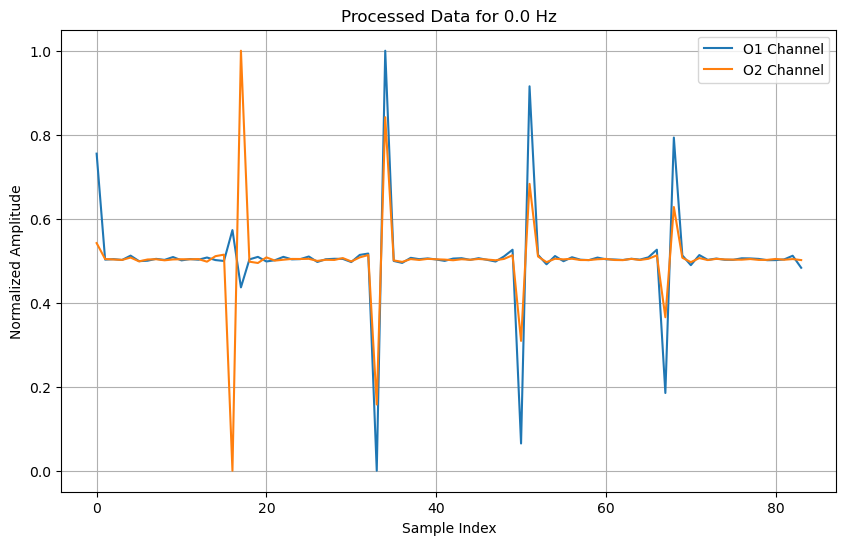

Processing for frequency: 1.7000000476837167 Hz
Label (1.7000000476837167,) not found in the labels.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch

# Define the filter function
def apply_filter(data, sampling_rate, cutoff, filter_type, order=4):
    nyquist = 0.5 * sampling_rate
    normalized_cutoff = np.array(cutoff) / nyquist
    b, a = butter(order, normalized_cutoff, btype=filter_type, analog=False)
    return filtfilt(b, a, data, axis=0)

# Define the notch filter function
def apply_notch_filter(data, sampling_rate, notch_freq, quality_factor=30.0):
    nyquist = 0.5 * sampling_rate
    normalized_notch = notch_freq / nyquist
    b, a = iirnotch(normalized_notch, quality_factor)
    return filtfilt(b, a, data, axis=0)

# Normalize function: min-max normalization to scale between 0 and 1
def normalize_channel(channel):
    return (channel - np.min(channel)) / (np.max(channel) - np.min(channel))

# Function to process data for a given frequency
def process_frequency(signals, labels, target_label, sampling_rate=250, low_cutoff=1.0, high_cutoff=40.0, notch_freq=50.0, window_size=140):
    """
    Process signals for a specific target label (frequency).

    :param signals: The full signal array.
    :param labels: The corresponding labels.
    :param target_label: The target frequency label to process.
    :param sampling_rate: Sampling rate in Hz.
    :param low_cutoff: Low cutoff for bandpass filter.
    :param high_cutoff: High cutoff for bandpass filter.
    :param notch_freq: Notch filter frequency to remove.
    :param window_size: Window size for segmentation.
    :return: Processed and normalized average window for the target frequency.
    """
    # Extract indices for the target label
    labels_dict = {}
    for i, label in enumerate(labels):
        hashable_label = tuple(label) if isinstance(label, np.ndarray) else label
        if hashable_label not in labels_dict:
            labels_dict[hashable_label] = []
        labels_dict[hashable_label].append(i)

    if target_label not in labels_dict:
        print(f"Label {target_label} not found in the labels.")
        return None

    target_indices = labels_dict[target_label]
    target_signals = signals[target_indices, :]

    # Extract O1 and O2 channels
    o1_o2_channels = target_signals[:, 0:2]

    # Apply bandpass filter
    bandpass_filtered_data = apply_filter(o1_o2_channels, sampling_rate, [low_cutoff, high_cutoff], 'band')

    # Apply notch filter
    notch_filtered_data = apply_notch_filter(bandpass_filtered_data, sampling_rate, notch_freq)

    # Segment data into windows
    num_windows = notch_filtered_data.shape[0] // window_size
    windowed_data = notch_filtered_data[:num_windows * window_size].reshape(num_windows, window_size, 2)

    # Compute the average across all windows
    average_window = np.mean(windowed_data, axis=1)

    # Normalize the average window
    normalized_o1 = normalize_channel(average_window[:, 0])
    normalized_o2 = normalize_channel(average_window[:, 1])
    normalized_average_window = np.stack([normalized_o1, normalized_o2], axis=1)

    return normalized_average_window

# Function to plot processed data
def plot_processed_data(data, title="Processed Data for Target Frequency"):
    plt.figure(figsize=(10, 6))
    plt.plot(data[:, 0], label="O1 Channel")
    plt.plot(data[:, 1], label="O2 Channel")
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
def process_and_plot_for_frequencies(signals, labels, target_frequencies, **kwargs):
    for freq in target_frequencies:
        print(f"Processing for frequency: {freq} Hz")
        processed_data = process_frequency(signals, labels, (freq,), **kwargs)
        if processed_data is not None:
            plot_processed_data(processed_data, title=f"Processed Data for {freq} Hz")

# Example target frequencies


target_frequencies = [0.0,1.7000000476837168]

# Call the function with signals, labels, and target frequencies
process_and_plot_for_frequencies(signals, labels, target_frequencies,
                                 sampling_rate=250,
                                 low_cutoff=1.0, 
                                 high_cutoff=40.0,
                                 notch_freq=50.0,
                                 window_size=147)



# Data processing anf classification


In [ ]:
sampling_rate, lowcut, highcut = record.fs, 4, 30.0
print(sampling_rate)
o1_o2_channels = signals[:, 0:2]

processor = EMGProcessor(sampling_rate,lowcut=lowcut,highcut=highcut)
extractor = EMGFeatureExtractor(sampling_rate)

extractor.load_data(o1_o2_channels)
extractor.raw_data.shape


250


(49782, 2)

Filtered data shape: (49782, 1)
Created 680 windows of shape (147, 1)


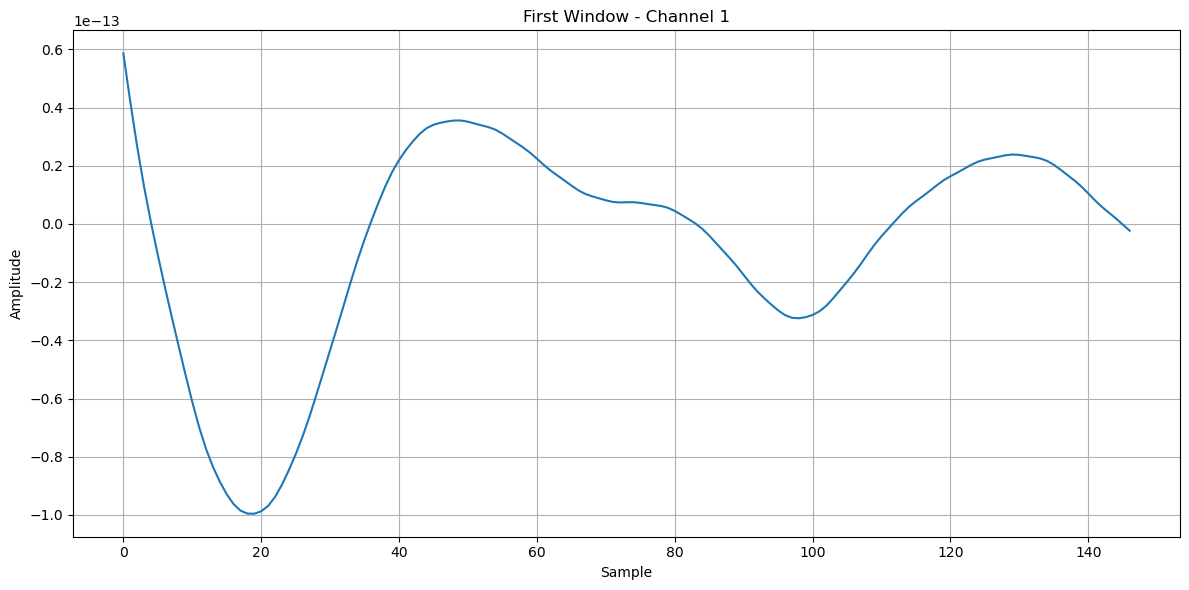

In [ ]:
labels_processor = EMGProcessor(sampling_rate,lowcut=lowcut,highcut=highcut)
labels_extractor = EMGFeatureExtractor(sampling_rate)

labels_extractor.load_data(labels)
labels_extractor.filter_data(bandpass_filter=processor.bandpass_filter, notch_filter=processor.notch_filter)
labels_extractor.create_windows(window_size=147, overlap=74)
labels_extractor.plot_first_window()

Filtered data shape: (49782, 2)
Created 338 windows of shape (147, 2)


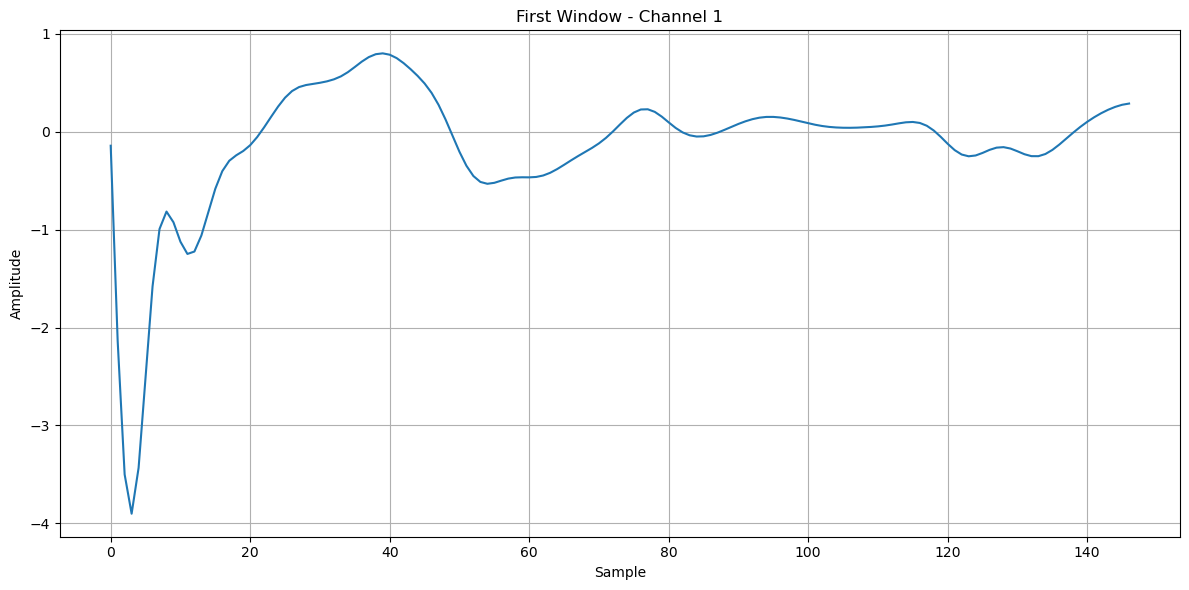

In [ ]:
extractor.filter_data(bandpass_filter=processor.bandpass_filter, notch_filter=processor.notch_filter)
extractor.create_windows(window_size=147, overlap=0)
extractor.plot_first_window()



In [ ]:
labels.shape

(49782, 1)

In [ ]:
import numpy as np
from collections import Counter

def create_windowed_labels(labels, window_size=140):
    """
    Create new labels for windowed data by selecting the most repeated label in each window.

    :param labels: 1D or 2D array of original labels.
    :param window_size: Number of samples per window.
    :return: 1D array of new labels (one per window).
    """
    # Ensure labels are a numpy array
    labels = np.array(labels)

    # Convert labels to hashable types (e.g., tuple) if they are arrays
    if labels.ndim > 1:
        labels = [tuple(label) for label in labels]

    # Calculate the number of complete windows
    num_windows = len(labels) // window_size

    # Initialize a list to store new labels
    new_labels = []

    # Iterate over windows
    for i in range(num_windows):
        # Extract the labels for the current window
        window_labels = labels[i * window_size:(i + 1) * window_size]

        # Count occurrences of each label in the window
        label_counts = Counter(window_labels)

        # Get the most common label
        most_common_label = label_counts.most_common(1)[0][0]

        # Append the most common label to the new labels list
        new_labels.append(most_common_label)
   

    return np.array(new_labels)


window_size = 140

# Create new labels
new_labels = create_windowed_labels(labels, window_size).flatten()

# Print the results
print("New Labels for Windowed Data:")

print(new_labels.shape)


New Labels for Windowed Data:
(355,)


## Feature extraction

In [ ]:

feature_names = [
        "Zero Crossing",
        "Waveform Length", 
        "Difference Absolute STD",
        "Integral Absolute Value",
        "Log Detector", 
        "Mean Absolute Value",
        "Root Mean Square",
        "Absolute Temporal Moment",
        "Variance",
        "V-Order",
        "Mean Frequency", 
        "Maximum Amplitude", 
        "Peak Frequency",
        "Mean Power",
        "Total Power", 
        "Variance of Central Frequency"
    ]

Feature extraction complete.
Features for the first window, first channel:
Zero Crossing: 6.0
Waveform Length: 13.142790243898801
Difference Absolute STD: 0.22983956262388466
Integral Absolute Value: 58.376755033927274
Log Detector: 0.19803316569186996
Mean Absolute Value: 0.39712078254372296
Root Mean Square: 0.7150020090747731
Absolute Temporal Moment: 0.511227872980962
Variance: 0.492666890950729
V-Order: 1.284544904657209
Mean Frequency: 20.15583097181471
Maximum Amplitude: 3.901492793609139
Peak Frequency: 3.4013605442176873
Mean Power: 0.511227872980962
Total Power: 75.15049732820141
Variance of Central Frequency: 453.0707917894076


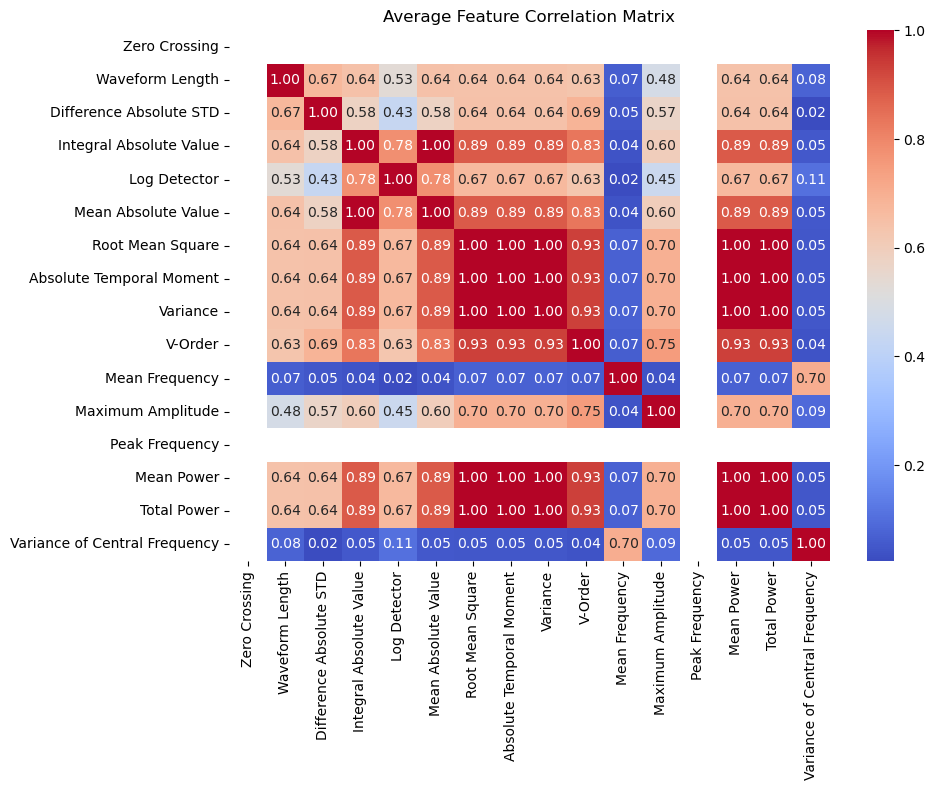

In [ ]:
def extract_features_and_plot(extractor, feature_names, filename_prefix):
    features = extractor.extract_features()
    print(f"Features for the first window, first channel:")
    for i, name in enumerate(feature_names):
        print(f"{name}: {features[0, 0, i]}")

    correlation = extractor.compute_average_correlation(features)
    extractor.plot_correlation_matrix(correlation, feature_names=feature_names, filename=f"{filename_prefix}_correlation_matrix.png")
    return features, correlation

features,correlation = extract_features_and_plot(extractor, feature_names, "feature_extraction")



Removed 6 features. Retained 10 features.
Removed Features: {'Variance', 'V-Order', 'Absolute Temporal Moment', 'Total Power', 'Mean Power', 'Mean Absolute Value'}
Number of Retained Features: 10
Retained Features: ['Zero Crossing', 'Waveform Length', 'Difference Absolute STD', 'Integral Absolute Value', 'Log Detector', 'Root Mean Square', 'Mean Frequency', 'Maximum Amplitude', 'Peak Frequency', 'Variance of Central Frequency']


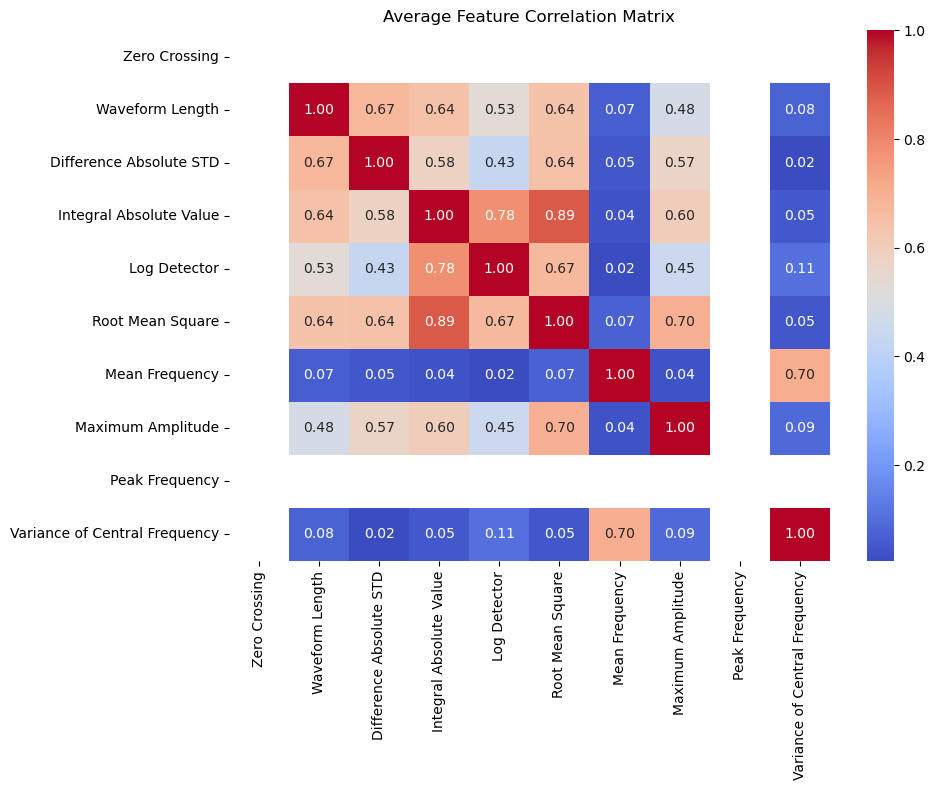

In [ ]:

# Helper Functions
def remove_highly_correlated_features(extractor_concat, correlation_matrix, feature_names, threshold=0.9,filename="feature_extraction_reduced_correlation_matrix.png"):
    correlation_df = pd.DataFrame(correlation_matrix, columns=feature_names, index=feature_names)
    
    # Remove highly correlated features
    reduced_correlation_matrix, removed_features = extractor_concat.remove_highly_correlated_features(
        correlation_df, threshold=0.9
    )

    # Plot the reduced correlation matrix
    extractor_concat.plot_correlation_matrix(reduced_correlation_matrix, feature_names=reduced_correlation_matrix.columns)

    # Print summary
    print(f"Removed Features: {removed_features}")
    print(f"Number of Retained Features: {len(reduced_correlation_matrix.columns)}")
    
    # Ensure feature names are updated after removing redundant features
    retained_features = reduced_correlation_matrix.columns.tolist()
    print(f"Retained Features: {retained_features}")
    
     # Get the indices of retained features in the feature_names list
    retained_indices = [feature_names.index(feature) for feature in retained_features]


    return retained_features,retained_indices

# Remove highly correlated features
retained_features, retained_indices = remove_highly_correlated_features(extractor,correlation,feature_names)


In [ ]:
# Prepare the feature matrix (filter to only retained features)
num_windows, num_channels, num_features = features.shape

# Reshape and reduce features for retained features
filtered_features = []
for ch in range(num_channels):
    # Convert features for this channel to a DataFrame
    X_df = pd.DataFrame(features[:, ch, :], columns=feature_names)
    # Select only the retained features
    X_reduced = X_df[retained_features].values
    filtered_features.append(X_reduced)
# Stack the features across channels
filtered_features = np.stack(filtered_features, axis=1)  # Shape: (num_windows, num_channels, num_retained_features)
filtered_features.shape

(338, 2, 10)

In [ ]:
def discretize_labels(labels, num_bins=3):
    """
    Discretize continuous labels into discrete classes by binning.

    :param labels: Array of continuous labels.
    :param num_bins: Number of bins to categorize the labels.
    :return: Array of discrete labels.
    """
    bins = np.linspace(min(labels), max(labels), num_bins + 1)
    return np.digitize(labels, bins) - 1  # Bin indices start from 0

discrete_labels = discretize_labels(new_labels.flatten(), num_bins=4)

In [ ]:

def compute_permutation_importance_per_channel(filtered_features, labels, feature_names, channels):
    # Initialize storage for channel-wise feature importances
    channel_importances = []

    # Iterate over each channel
    for ch in range(channels):
        print(f"Processing Channel {ch + 1}/{channels}...")

        # Extract features for the current channel
        X_channel = filtered_features[:, ch, :]  # Shape: (num_windows, num_retained_features)

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X_channel, labels, test_size=0.3, random_state=42, stratify=labels)

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train SVC model
        svc_model = SVC(kernel="rbf", random_state=42)
        svc_model.fit(X_train_scaled, y_train)

        # Compute permutation importance
        importance = permutation_importance(svc_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
        channel_importances.append(importance.importances_mean)  # Mean importance for each feature

    # Convert to a DataFrame
    feature_importances = pd.DataFrame(channel_importances, columns=feature_names)
    mean_importance = feature_importances.mean(axis=0)  # Mean across channels

    # Return DataFrame with mean importance
    return pd.DataFrame({"Feature": feature_names, "Importance": mean_importance}).sort_values(by="Importance", ascending=False)


def plot_feature_importances(feature_importances, top_n=4, filename="feature_importances.png"):

    # Select top-n features
    top_features = feature_importances.head(top_n)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Top {top_n} Features by Permutation Importance")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.savefig(filename)
    plt.show()

    print(f"Saved feature importance plot as {filename}")
    
 
# Compute feature importance across channels
feature_importances = compute_permutation_importance_per_channel(filtered_features, discrete_labels, retained_features, num_channels)

# Print top features
print("Feature Importances Across Channels:")
print(feature_importances)

# Plot and save the top 4 features
plot_feature_importances(feature_importances, top_n=4, filename="classification_task_top_4_features_importance.png")


# Save top features for further processing
top_4_features = feature_importances.head(4)
print("Top 4 Features:")
print(top_4_features)

Processing Channel 1/2...


ValueError: Found input variables with inconsistent numbers of samples: [338, 355]

In [ ]:

def train_and_evaluate_classification_model(X, y, filename_prefix):
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    
    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Support Vector Machine
    svc = SVC(kernel="rbf", random_state=42)
    svc.fit(X_train_scaled, y_train)
    y_pred_svc = svc.predict(X_test_scaled)
    print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svc):.2f}")
    print(classification_report(y_test, y_pred_svc))

    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_train_lda = lda.fit_transform(X_train_scaled, y_train)
    X_test_lda = lda.transform(X_test_scaled)
    
    # Fit and predict
    lda.fit(X_train_scaled, y_train)
    y_pred_lda = lda.predict(X_test_scaled)

    # Evaluate LDA
    accuracy_lda = accuracy_score(y_test, y_pred_lda)
    print(f"LDA Accuracy: {accuracy_lda:.2f}")
    print(classification_report(y_test, y_pred_lda))

    # Plot LDA Projection
    plt.figure(figsize=(10, 6))
    for label in np.unique(y_train):
        plt.scatter(X_train_lda[y_train == label, 0], X_train_lda[y_train == label, 1], label=f"Class {label}")
    plt.title("LDA Projection")
    plt.legend()
    plt.grid()
    plt.savefig(f"{filename_prefix}_lda_projection.png")
    plt.show()
    

    # Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_scaled, y_train)
    y_pred_rf = rf.predict(X_test_scaled)
    print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
    print(classification_report(y_test, y_pred_rf))

    # Plot a decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(rf.estimators_[0], feature_names=[f"Feature_{i}" for i in range(X_train_scaled.shape[1])], filled=True)
    plt.savefig(f"{filename_prefix}_decision_tree.png")
    plt.show()

# Save top features for further processing
top_4_features = feature_importances.head(4)
print("Top 4 Features:")
print(top_4_features)

new_top_4_features = feature_importances.head(4)["Feature"].tolist()

new_top_4_indices = [retained_features.index(feature) for feature in new_top_4_features]

    # Select the top features from the filtered features
filtered_training_features = filtered_features[:, :, new_top_4_indices]


training_features = filtered_training_features.reshape(num_windows, -1)

train_and_evaluate_classification_model(training_features, discrete_labels, "classification")

NameError: name 'feature_importances' is not defined